# Nextra Energy Stock Price Prediction

1. Imports

In [1]:
#Imports
import math
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib.pyplot import figure
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

2. Ingest Data

In [3]:
nee = yf.download('NEE', start='2019-01-01', end='2023-11-17')
nee

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,43.169998,43.325001,42.252499,42.457500,37.930450,10549600
2019-01-03,42.477501,42.790001,42.167500,42.352501,37.836651,9260800
2019-01-04,42.287498,43.147499,42.165001,43.132500,38.533485,10848800
2019-01-07,42.912498,43.235001,42.625000,43.070000,38.477638,9478000
2019-01-08,43.037498,43.447498,42.892502,43.384998,38.759048,10599600
...,...,...,...,...,...,...
2023-11-10,55.000000,55.369999,54.509998,55.139999,54.694923,12776100
2023-11-13,55.049999,55.060001,53.810001,54.500000,54.060093,8951800
2023-11-14,56.080002,57.740002,55.450001,57.549999,57.085472,13399500


<Axes: xlabel='Date'>

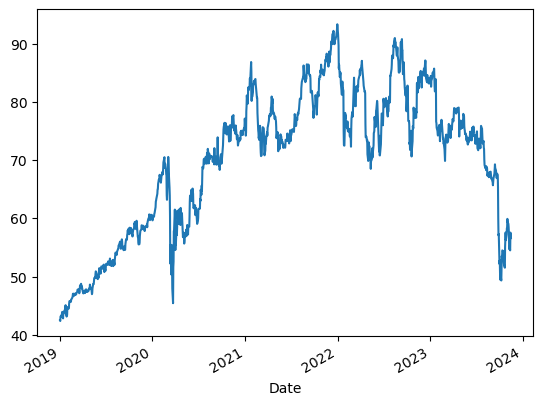

In [5]:
nee['Close'].plot()

3. Making an array for price difference in 2 days

In [6]:
nee['Close First Difference'] = (nee['Close'] - nee['Close'].shift(1))
nee_pr = np.array(nee.reset_index()['Close First Difference'].dropna())

In [7]:
res=adfuller(nee['Close First Difference'].dropna())
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.945752
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [8]:
from statsmodels.tsa.arima.model import ARIMA

def searchARIMA(data, exog, max_p, max_q):
    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                if len(exog) == len(data):
                    model = ARIMA(data, order=(i, 0, j), exog=exog, trend='n')
                else:
                    model = ARIMA(data, order=(i, 0, j), trend='n')
                
                res_nee = model.fit()
                aic[i, j] = res_nee.aic
                bic[i, j] = res_nee.bic
                print('p:', i, ' q:', j, ' aic:', aic[i, j], ' bic:', bic[i, j])
                
            except Exception as e:
                print(f'Error for p={i}, q={j}: {e}')
                continue



4. Trying p and q values for ARIMA model

In [9]:
nee_n = len(nee_pr)
nee_exog = np.ones(nee_n)
searchARIMA(nee_pr, nee_exog, max_p=6, max_q=3)

p: 0  q: 0  aic: 4020.738995859639  bic: 4030.965280077053
p: 0  q: 1  aic: 4022.1093133327017  bic: 4037.448739658823
p: 0  q: 2  aic: 4021.583670396012  bic: 4042.0362388308404
p: 1  q: 0  aic: 4022.054585278517  bic: 4037.3940116046383
p: 1  q: 1  aic: 4023.286731804922  bic: 4043.7393002397503
p: 1  q: 2  aic: 4017.743226970477  bic: 4043.308937514012
p: 2  q: 0  aic: 4021.7304556451204  bic: 4042.1830240799486
p: 2  q: 1  aic: 4023.685689101697  bic: 4049.251399645232
p: 2  q: 2  aic: 4003.858653967603  bic: 4034.5375066198453
p: 3  q: 0  aic: 4023.574919900707  bic: 4049.140630444242
p: 3  q: 1  aic: 4025.2682997966044  bic: 4055.9471524488467
p: 3  q: 2  aic: 4002.285618265455  bic: 4038.077613026405
p: 4  q: 0  aic: 4022.6585159256447  bic: 4053.337368577887
p: 4  q: 1  aic: 4006.631335879195  bic: 4042.4233306401447


C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 4  q: 2  aic: 4003.897634876159  bic: 4044.802771745816
p: 5  q: 0  aic: 4019.4424699401206  bic: 4055.2344647010705
p: 5  q: 1  aic: 4006.824457906373  bic: 4047.72959477603
p: 5  q: 2  aic: 4008.6978230892346  bic: 4054.7161020675985


In [10]:
from statsmodels.tsa.arima.model import ARIMA
order = (3,0, 2) 
model = ARIMA(nee_pr, order=order)
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1994.143
Date:                Fri, 15 Dec 2023   AIC                           4002.286
Time:                        19:02:19   BIC                           4038.078
Sample:                             0   HQIC                          4015.753
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.038      0.306      0.759      -0.063       0.086
ar.L1         -1.5655      0.095    -16.421      0.000      -1.752      -1.379
ar.L2         -0.6436      0.106     -6.079      0.0

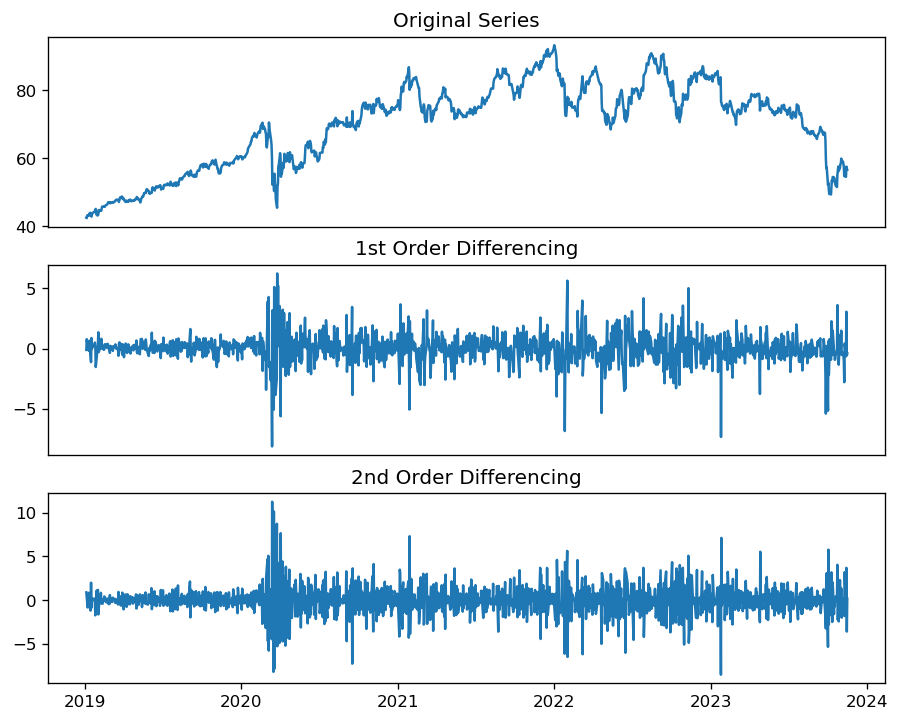

In [11]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(nee.Close); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(nee.Close.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(nee.Close.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

5. Train test split

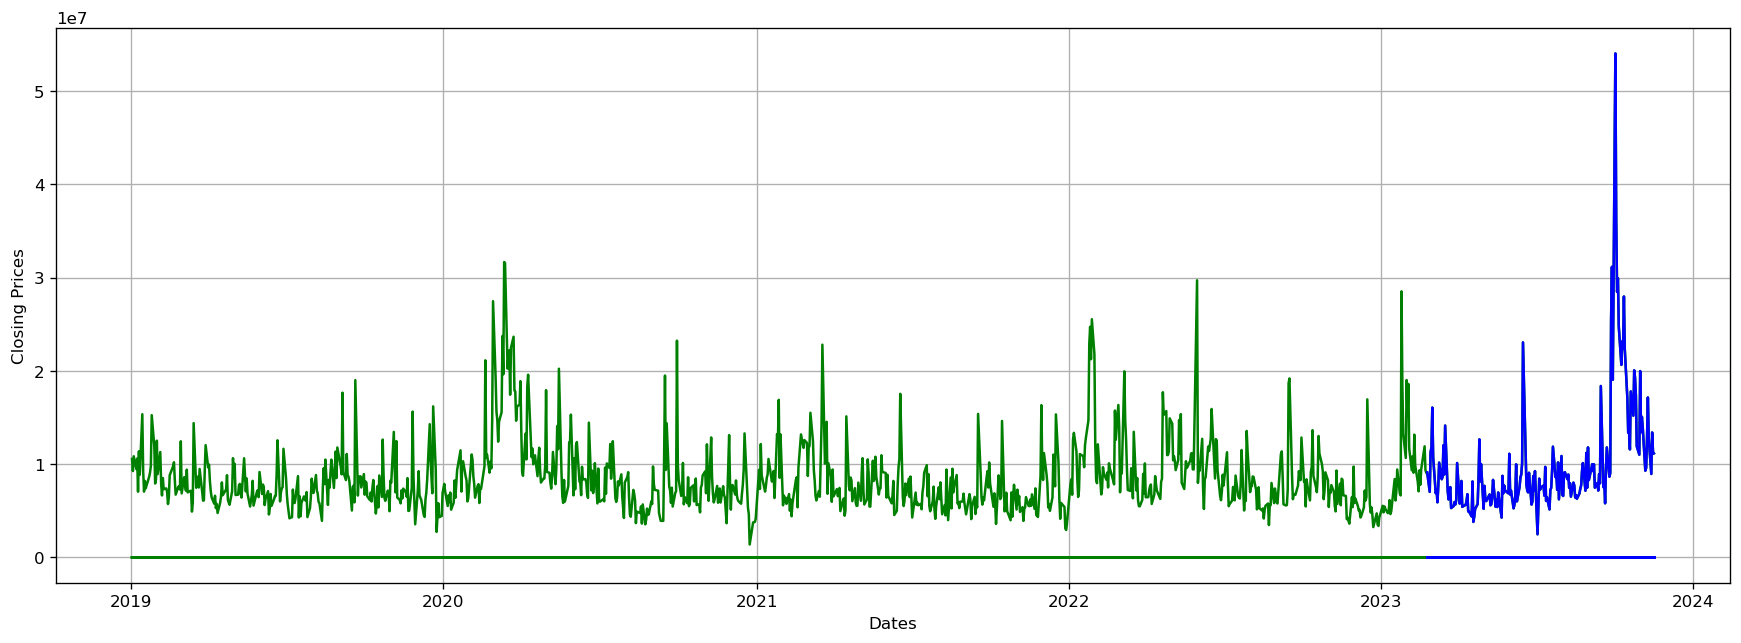

In [12]:
train_data, test_data = nee[0:int(len(nee)*0.85)], nee[int(len(nee)*0.85):]
training_data = train_data['Close'].values
testing_data = test_data['Close'].values
plt.figure(figsize=(18,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nee, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')

6. Final ARIMA model

In [13]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(testing_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(testing_data, model_predictions)
RMSE_error = math.sqrt(MSE_error)

print('Testing Mean Squared Error is {}'.format(MSE_error))
print('Testing Root Mean Squared Error is {}'.format(RMSE_error))


C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\base\

Testing Mean Squared Error is 1.301375383066943
Testing Root Mean Squared Error is 1.140778411027726


In [14]:
model_predictions = pd.DataFrame(model_predictions)

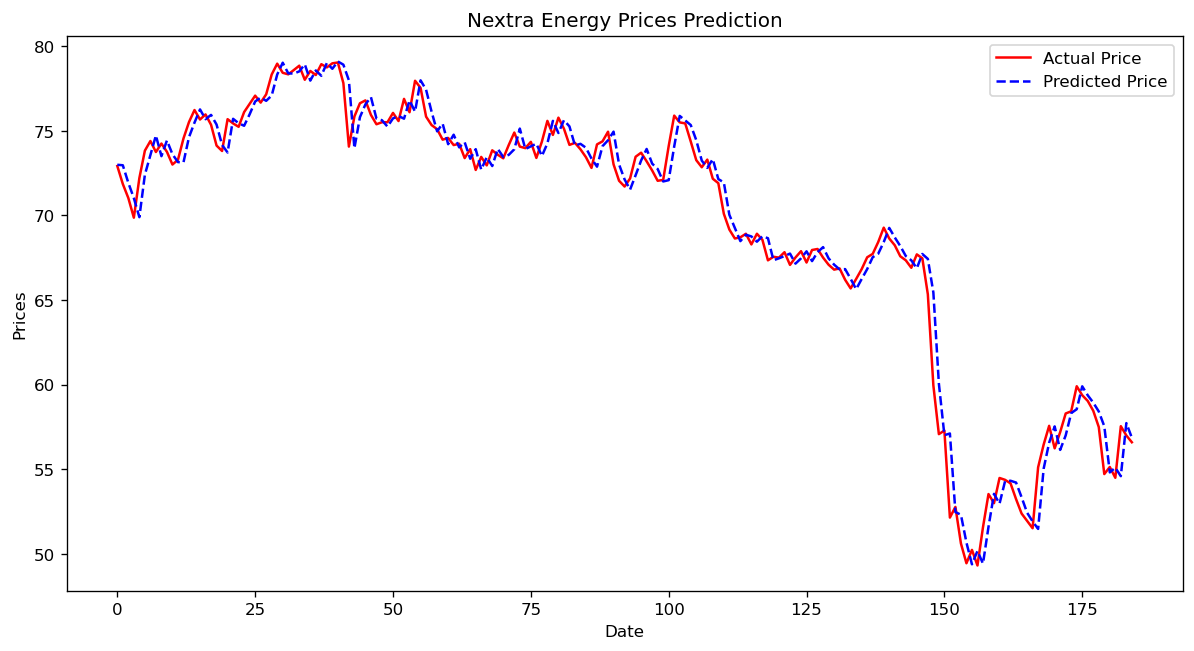

In [15]:
test_set_range = nee[int(len(nee)*0.85):].index
plt.figure(figsize=(12,6))
plt.plot(testing_data, color='red',label='Actual Price')
plt.plot(model_predictions, color='blue',linestyle='dashed',label='Predicted Price')
#plt.plot(test_data, color='red', label='Actual Price')
plt.title('Nextra Energy Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

7. LSTM Model

In [16]:
data = nee.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .85))
training_data_len

1045

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00205851],
       [0.        ],
       [0.01529185],
       ...,
       [0.29794635],
       [0.28716364],
       [0.27932162]])

In [18]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00205851, 0.        , 0.01529185, 0.01406653, 0.02024207,
       0.01656614, 0.02930939, 0.03087783, 0.00892022, 0.02602557,
       0.02582948, 0.02979955, 0.03274025, 0.03906289, 0.04886537,
       0.05327646, 0.02347691, 0.01499778, 0.01690926, 0.02048715,
       0.04690483, 0.04121945, 0.04259179, 0.04293484, 0.04259179,
       0.05852082, 0.06665682, 0.06665682, 0.06793119, 0.06587268,
       0.06469635, 0.07170509, 0.07822375, 0.0795471 , 0.08405624,
       0.09175122, 0.09052591, 0.0922413 , 0.08528155, 0.08974169,
       0.08895748, 0.09229036, 0.09268247, 0.08900654, 0.09077091,
       0.09454489, 0.09846589, 0.10527862, 0.10567072, 0.10571971,
       0.10699408, 0.10518057, 0.09356465, 0.10027933, 0.1102779 ,
       0.12017835, 0.11860999, 0.12542271, 0.12012937, 0.11032689])]
[0.11718866737814027]

[array([0.00205851, 0.        , 0.01529185, 0.01406653, 0.02024207,
       0.01656614, 0.02930939, 0.03087783, 0.00892022, 0.02602557,
       0.02582948, 0.02979955, 0.03

In [19]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(35))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = model.fit(x_train, y_train,validation_data= (x_test, y_test),batch_size=1, epochs=10)

Epoch 1/10
985/985 [==============================] - 36s 33ms/step - loss: 0.0043 - val_loss: 4808.3369
Epoch 2/10
985/985 [==============================] - 32s 32ms/step - loss: 0.0019 - val_loss: 4809.2993
Epoch 3/10
985/985 [==============================] - 36s 36ms/step - loss: 0.0013 - val_loss: 4812.6177
Epoch 4/10
985/985 [==============================] - 32s 33ms/step - loss: 0.0013 - val_loss: 4813.0059
Epoch 5/10
985/985 [==============================] - 33s 34ms/step - loss: 0.0012 - val_loss: 4807.7954
Epoch 6/10
985/985 [==============================] - 33s 33ms/step - loss: 0.0013 - val_loss: 4812.0928
Epoch 7/10
985/985 [==============================] - 34s 34ms/step - loss: 0.0012 - val_loss: 4811.3843
Epoch 8/10
985/985 [==============================] - 33s 33ms/step - loss: 0.0011 - val_loss: 4812.3237
Epoch 9/10
985/985 [==============================] - 33s 34ms/step - loss: 0.0011 - val_loss: 4809.9731
Epoch 10/10
985/985 [==============================] - 

In [21]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 [==============================] - 1s 24ms/step


1.3475980028693495

C:\Users\Aditya\AppData\Local\Temp\ipykernel_23600\1961609819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


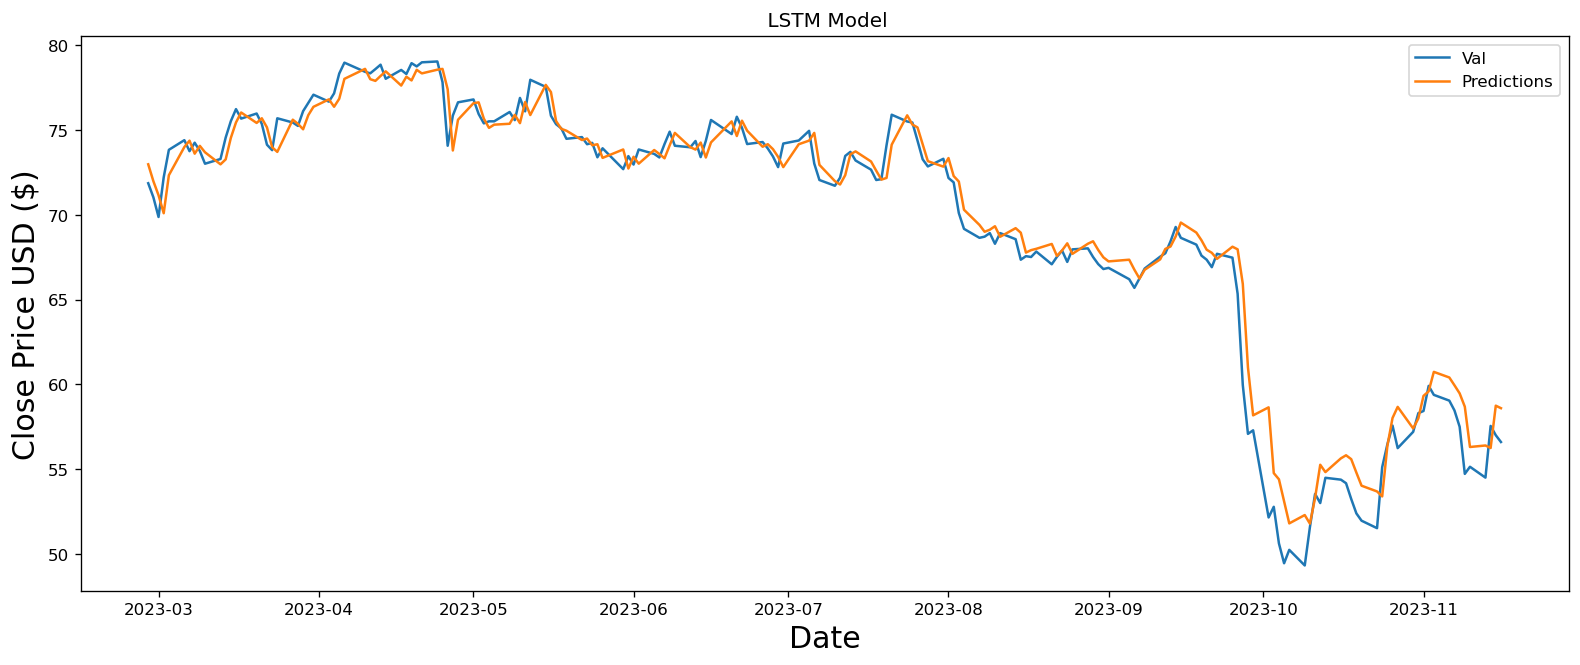

In [22]:
#Out of sample data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title(' LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='upper right')
plt.show()

Text(0, 0.5, 'MSE')

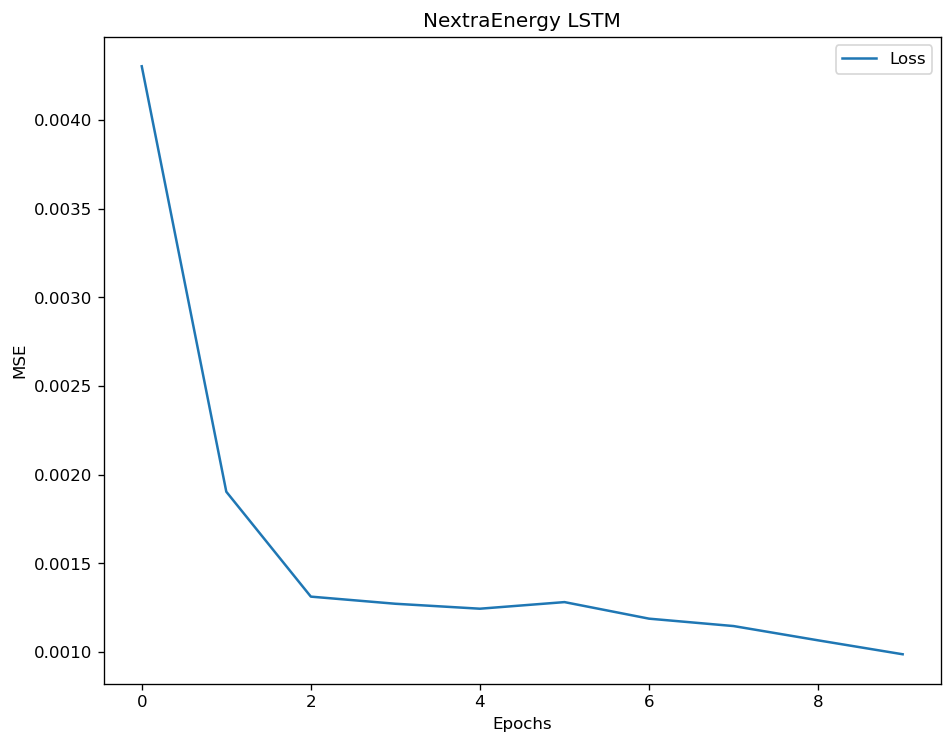

In [24]:
#Loss plot 
plt.plot(lstm_history.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('NextraEnergy LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')